In [1]:
import re
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
def stepcounter(idx:int,idxmax:list):
    lidx=idx+1
    lst=[]

    for i in range(len(idxmax)):
        lst=[np.mod(lidx,idxmax[-i-1])] + lst
        lidx=lidx//idxmax[-i-1]
    return (idx+1,lst)
    


def read_outfile(linfile_name:str,nopickle:bool=False)->tuple[dict,pd.DataFrame]:
    run_info={}
    header=True
    pickle=False
    if not os.path.isfile(linfile_name):
        print(f"Unable to find {linfile_name}")
        return

    if os.path.isfile(linfile_name+".pkl") and not nopickle:
        print(f"Found the pickle preproces {linfile_name+'.pkl'}")
        pickle=True
        data_df=pd.read_pickle(linfile_name+'.pkl')
        
    with open(linfile_name) as lfile:
        for lline in lfile:
            if("[INIT ML][0]number of MultiLevels=" in lline and header):
                run_info["n mlev"] = int(re.split("=",lline)[1])
                run_info["nit per ml"]=[None]* run_info["n mlev"]
                gbidx=toridx=-1
                run_info["frozen t"]={}
                for lid in range(run_info["n mlev"]+1):
                    lsize =  run_info["glbt"]//2**(lid+1)
                    run_info["frozen t"][lid] = [(i+1) * lsize -1 for i in range(2**(lid+1)-1) ]
            elif("[GEOMETRY_INIT][0]Global size is" in lline and header):
                stringsplit = re.split("x| ",lline)
                run_info["glbt"]=int(stringsplit[3])
                print(f'Global lattice temporal extent T={run_info["glbt"]}')
            elif("[INIT ML][0]ML tuning level=" in lline and header):
                tunelev = int(re.split("=",lline)[1]) 
                run_info["nit per ml"]=run_info["nit per ml"][:(tunelev+1)]
                print(f"Output file contain tuning on lev={tunelev}")
                print(f'Each conf contains {np.prod(run_info["nit per ml"])} different measures split along {tunelev+1} remaining update levels')
                store=[]
            elif("[INIT ML][0]lev " in lline and header):
                stringsplit = re.split("=| ",lline)
                llevid=int(stringsplit[2])
                lup=int(stringsplit[4])
                run_info["nit per ml"][llevid]=lup

            elif("[MAIN][0]Configuration " in lline):
                if(pickle):
                    break
                cnfgid=int(lline.split()[1])
                assert(np.mod(gbidx,np.prod(run_info["nit per ml"]))== np.prod(run_info["nit per ml"])-1)
                assert(np.mod(toridx,np.prod(run_info["nit per ml"]))== np.prod(run_info["nit per ml"])-1)
                header=False
            elif("[MEASURE_TUNE][0]Glueball operator tune measure" in lline):
                (gbidx,idxlst) = stepcounter(gbidx,run_info["nit per ml"])
            elif("[MEASURE_TUNE][0]Torellon operator tune measure" in lline):
                (toridx,idxlst) = stepcounter(toridx,run_info["nit per ml"])
            elif("[Measure ML][0]1pt function P=" in lline or "[Measure ML][0]1ptTor function P=" in lline):
                stringsplit = lline.split()
                if(stringsplit[1]=='ML][0]1pt'):
                    typestring="glueball"
                else:   
                    typestring="torellon"
                plst = list(map(lambda x:int(x), re.split("P=\\(|,|\\)", stringsplit[3] )[1:-1]))
                irrepstring = re.split("=", stringsplit[4] )[1]
                evstring = re.split("=", stringsplit[6] )[1]
                chargestring = re.split("=", stringsplit[7] )[1]
                data_dic={"cfgid":cnfgid,"type":typestring,"momenta": plst ,"irrep":irrepstring,"charge":chargestring,"ev":evstring}
                for i in range(tunelev+1):
                    data_dic["ML_index"+str(i)]=idxlst[i]
            elif("[Measure ML][0] t=" in lline):
                stringsplit = re.split("=|\\(|\\)| ",lline)[3:]
                data_dic["t"]=int(stringsplit[0])
                data_dic["values"]=[float(i) for i in stringsplit[1:-1] if i ]
                store.append(data_dic.copy())
    if( not pickle):
        if(toridx!=-1):
            print(f'Found {(toridx+1)//np.prod(run_info["nit per ml"])} torellons configuration measurements')
        if(gbidx!=-1):
            print(f'Found {(gbidx+1)//np.prod(run_info["nit per ml"])} glueballs configuration measurements')
        data_df = pd.DataFrame(store)
        data_df.to_pickle(linfile_name+'.pkl')

    print(f"Memory footprint of the df in Mb={data_df.memory_usage(deep=True).sum()/10**6}")
    return run_info,data_df
 
def data_select(dataf,type,irrep,charge,ev):
    data_df2=dataf[ ( dataf["type"]=="glueball" ) & ( dataf["irrep"]=="A1plusOhP" ) & ( dataf["charge"]=="+" ) & ( dataf["ev"]=="1/1" ) ]
    assert(data_df2.size>0)
    print(f'Available t indices {data_df2["t"].unique()}')
    nop=data_df2['values'].apply(lambda x: len(x)).unique()
    assert(len(nop)==1)
    print(f'Number of available operators {nop[0]}')
    return data_df2
            

def stdmean(ar):
    return np.std(ar)/np.sqrt(len(ar)-1)

def tune_meas(dataf,tid:int,opid:int,ncut:int,subvev:bool=False):
    stddev=0.
    data_df3=dataf[dataf["t"]==tid].copy()
    if(data_df3.size < 1):
        print(f"Choosen t({tid}) value is not included in the available data")
        return 
    data_df3.drop(columns=['stdmean'], inplace=True, errors='ignore')
    tunename = [ i for i in data_df3.columns if re.search("^ML_index",i)][-1]
    resttunename =["cfgid","t"] + [ i for i in data_df3.columns if re.search("^ML_index",i)][:-1]
    if(type(data_df3["values"].iloc[0])==list):
        assert len(data_df3["values"].iloc[0])>opid, f"Opid should be smaller than {len(data_df3['values'].iloc[0])}"
        data_df3['values']=data_df3['values'].apply(lambda x: x[opid])
        if(subvev):
            mean = data_df3['values'].mean()
            data_df3['values']=data_df3['values'].apply(lambda x: x-mean)
            data_df4=data_df3.groupby(resttunename).agg({'values':['mean']},axis=0).reset_index()['values']['mean']
            stddev = data_df4.std()/np.sqrt(len(data_df4)-1)
    check_elem=data_df3[data_df3[tunename]<ncut].groupby(resttunename, group_keys=True)["cfgid"].count().values
    assert(len(set(check_elem)) == 1)
    true_cut=check_elem[0]
    data_df4=data_df3[data_df3[tunename]<true_cut]
    data_df5 = data_df4[resttunename+ ["values"]].groupby(resttunename, group_keys=True).agg(['mean',stdmean]).reset_index().droplevel(0,axis=1).copy()
    data_df5.columns = resttunename + ["values","stdmean"]
    if(true_cut!=ncut):
        print(f"Maximal cut level used {true_cut}")
    return [stddev,data_df5]


In [3]:
rn_info,data_df1=read_outfile("/home/rago/HiRep/Run/hippo/Glueballs/b6.0874627/L14_anisotropic/production/Lt128/good_run_1/tune_run10_comparison_final_2/out_tune_measure_0")

Global lattice temporal extent T=128
Output file contain tuning on lev=1
Each conf contains 5000 different measures split along 2 remaining update levels
Found 1 torellons configuration measurements
Found 1 glueballs configuration measurements
Memory footprint of the df in Mb=11984.060132


In [4]:
#data_df1 = data_df1[data_df1["ML_index0"]!=0].copy()
data_df2=data_select(data_df1 , "glueball" , "A1plusOhP" , "+" ,"1/1" )

Available t indices [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125]
Number of available operators 176


In [13]:
tune_meas(data_df2,62,0,101,subvev=False)

Maximal cut level used 100


[0.0,
     cfgid   t  ML_index0     values   stdmean
 0       0  62          0  21.738779  0.011629
 1       0  62          1  21.760833  0.011922
 2       0  62          2  21.748332  0.012324
 3       0  62          3  21.766083  0.013238
 4       0  62          4  21.752206  0.014570
 5       0  62          5  21.779900  0.014481
 6       0  62          6  21.755658  0.014197
 7       0  62          7  21.781720  0.013967
 8       0  62          8  21.758011  0.012975
 9       0  62          9  21.756969  0.012759
 10      0  62         10  21.765235  0.012707
 11      0  62         11  21.749031  0.013197
 12      0  62         12  21.767342  0.014704
 13      0  62         13  21.780032  0.014973
 14      0  62         14  21.759869  0.013325
 15      0  62         15  21.758435  0.013809
 16      0  62         16  21.746167  0.013995
 17      0  62         17  21.766215  0.012026
 18      0  62         18  21.759193  0.014983
 19      0  62         19  21.766961  0.013853
 20    

In [14]:
data_df1[((data_df1["t"]==39) & (data_df1["type"]=="glueball") & (data_df1["ML_index0"]==0)& (data_df1["irrep"]=="A1plusOhP"))]["values"]

1135      [22.20263791, 0.0, 12.044547522, 0.0, 7.901100...
3575      [21.820524118, 0.0, 11.792900186, 0.0, 7.69483...
6015      [22.031186419, 0.0, 11.896205486, 0.0, 7.84036...
8455      [22.060105145, 0.0, 11.942386907, 0.0, 7.76881...
10895     [21.845300921, 0.0, 11.851121499, 0.0, 7.78976...
                                ...                        
232935    [22.236984956, 0.0, 11.872553915, 0.0, 7.94106...
235375    [22.048773705, 0.0, 12.07103645, 0.0, 7.846919...
237815    [22.004056449, 0.0, 11.996744423, 0.0, 7.84769...
240255    [21.919111589, 0.0, 11.926271919, 0.0, 7.75120...
242695    [22.065554666, 0.0, 11.942047164, 0.0, 7.95837...
Name: values, Length: 100, dtype: object

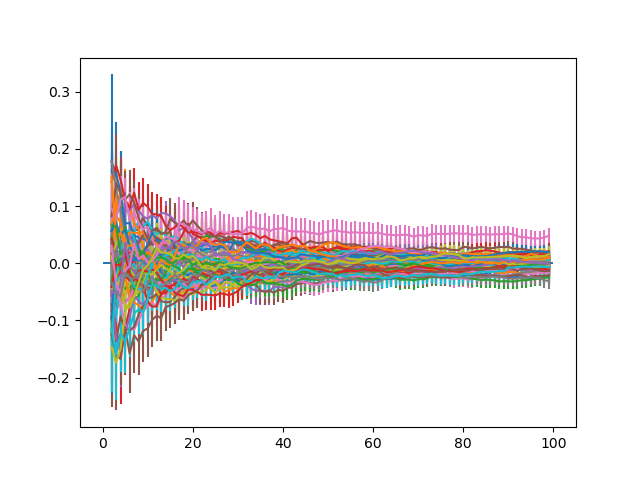

In [16]:
plt.clf()
x1=y1=e1=[]
for cut in range(2,100):
    [std,data_df3] = tune_meas(data_df2,62,0,cut,subvev=True)
    [ly1,le1] = [data_df3["values"].tolist(),data_df3["stdmean"].tolist()]
    lx1= [cut]*len(ly1)
    x1=x1+[lx1]
    y1=y1+[ly1]
    e1=e1+[le1]


x1 = np.array(x1).T
y1 = np.array(y1).T
e1 = np.array(e1).T
fig, ax = plt.subplots()


for i in range(len(x1)):
    ax.errorbar(x1[i], y1[i], yerr=e1[i], fmt="")  
ax.fill_between([0,max(x1.flatten())+1],[std,std],[-std,-std])
plt.show()


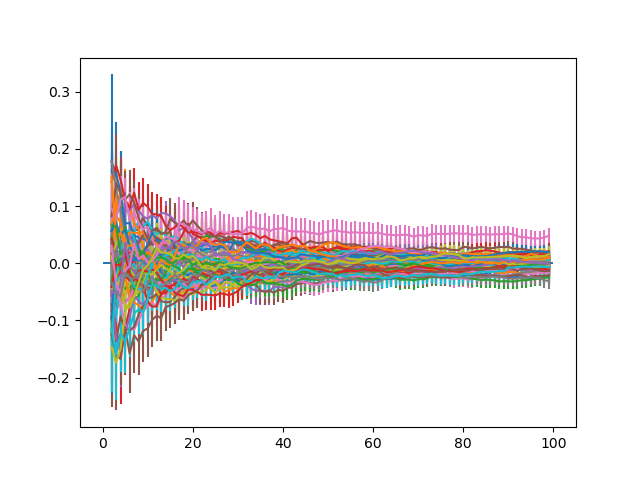

In [17]:
plt.clf()
fig, ax = plt.subplots()

for i in range(0,len(x1)):
    ax.errorbar(x1[i], y1[i], yerr=e1[i], fmt="")  
ax.fill_between([0,max(x1.flatten())+1],[std,std],[-std,-std])
plt.show()

In [18]:
[_,data_df3] = tune_meas(data_df2,62,2,100,subvev=True)

In [19]:
data_df3

,cfgid,t,ML_index0,values,stdmean
0,0,62,0,-0.018193,0.014537
1,0,62,1,0.023533,0.015869
2,0,62,2,-0.003805,0.016233
3,0,62,3,0.007273,0.015032
4,0,62,4,0.022774,0.018571
5,0,62,5,0.000649,0.017361
6,0,62,6,-0.024869,0.014340
7,0,62,7,0.020406,0.015556
8,0,62,8,-0.010466,0.016244
9,0,62,9,0.006702,0.017015


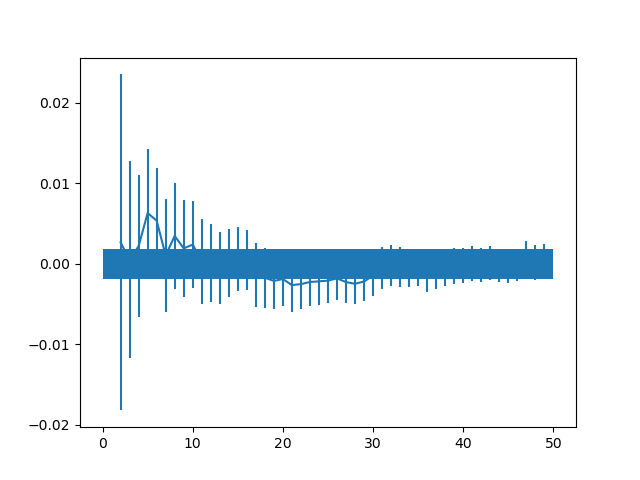

In [21]:
plt.clf()
x1=y1=e1=[]

for cut in range(2,50):
    [_,data_df4] = tune_meas(data_df3,62,_,cut)
    [ly1,le1] = [data_df4["values"].tolist(),data_df4["stdmean"].tolist()]
    lx1= [cut]*len(ly1)
    x1=x1+[lx1]
    y1=y1+[ly1]
    e1=e1+[le1]


x1 = np.array(x1).T
y1 = np.array(y1).T
e1 = np.array(e1).T
fig, ax = plt.subplots()


for i in range(len(x1)):
    ax.errorbar(x1[i], y1[i], yerr=e1[i], fmt="")  
ax.fill_between([0,max(x1.flatten())+1],[std,std],[-std,-std])
plt.show()

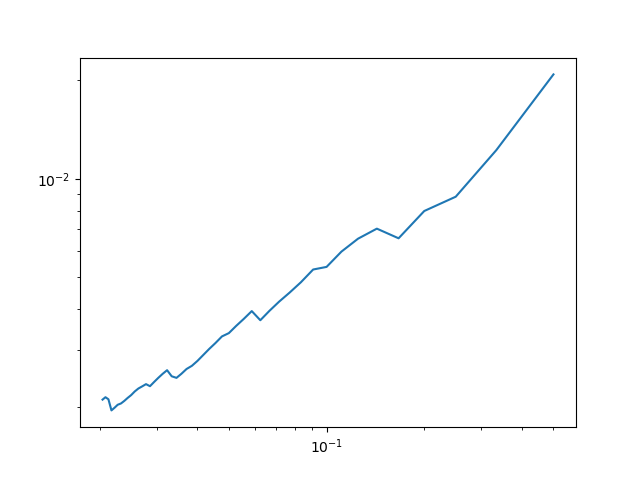

In [23]:
plt.clf()
fig, ax = plt.subplots()
for i in range(len(x1)):
    ax.plot(1/x1[i], e1[i]) 
plt.yscale('log')
plt.xscale('log')
plt.show()
